In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
from scipy import signal

In [2]:
def filtragem(signal, ord=5,f_pa=.05, f_pb=50, Fs=500):
  #Inputs
  #- ord: Ordem do filtro Butterworth
  #- f_pa: Frequencia passa-alta do filtro
  #- f_pb: Frequência passa-baixa do filtro
  #- Fs: Frequência de amostragem do sinal
  #- signal: Sinal a ser filtrado
  #Output
  #- signal_f: Sinal filtrado

  f_pb_n = f_pb/Fs
  f_pa_n = f_pa/Fs
  signal_f = np.zeros(signal.shape)

  sos = sp.signal.butter(ord,[f_pa_n,f_pb_n],btype='band',analog=False,output='sos')
  for i in range(signal_f.shape[1]-2):
    signal_f[:,i] = sp.signal.sosfiltfilt(sos,signal[:,i])
  return signal_f





def preparo(ds,y_certo,passo=.5,duracao=1,Fs=500):
  qtd_seq = ds.shape[0]//(Fs*duracao*passo)
  intersec = Fs*(duracao-passo)
  dados_final = np.zeros((int(qtd_seq),int(duracao*Fs),6*ds.shape[1]))
  y_final = np.zeros((int(qtd_seq),int(duracao*Fs)))
  for n_seq in range(int(qtd_seq)):
    pos = n_seq*intersec
    seq = ds[pos:pos+duracao*Fs,:]
    delta = filtragem(seq,f_pa=2,f_pb=4)
    theta = filtragem(seq,f_pa=4,f_pb=8)
    alfa = filtragem(seq,f_pa=8,f_pb=12)
    beta = filtragem(seq,f_pa=12,f_pb=30)
    gamma = filtragem(seq,f_pa=30)
    dados_final[i,:,:] = np.concatenate((seq,delta,theta,alfa,beta,gamma),axis=1)
    y_final[i,:] = y_certo[pos:pos+duracao*Fs]
    
  return dados_final, y_final

  

In [3]:
train = pd.read_csv('Train.csv',delimiter=';')
val = pd.read_csv('Validation.csv',delimiter=';')
test = pd.read_csv('Test.csv',delimiter=';')

eliminar = train.columns[-3]

train = train.drop(columns=eliminar)
val = val.drop(columns=eliminar)
test = test.drop(columns=eliminar)

FileNotFoundError: ignored

In [ ]:
features = train.columns[:-1]

train = train.to_numpy()
val = val.to_numpy()
test = test.to_numpy()

In [ ]:
x_train, y_train = train[:,:-1], train[:,-1:]
x_val, y_val = val[:,:-1], val[:,-1:]
x_test, y_test = test[:,:-1], test[:,-1:]

In [ ]:
x_train, y_train = preparo(x_train,y_train)
x_val, y_val = preparo(x_val,y_val)
x_test, y_test = preparo(x_test,y_test)

In [ ]:
train_mean = x_train.mean(axis=0)
train_std = x_train.std(axis=0)

x_train = (x_train - train_mean)/train_std
x_val = (x_val - train_mean)/train_std
x_test = (x_test - train_mean)/train_std

In [ ]:
stride = 500
batch = 1
train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val, y_val, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

test = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test, y_test, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

In [7]:
stride = 500
# sig = layers.Input((stride,len(features)))
sig = layers.Input((stride,19))
y_train = np.zeros((2,1))

In [8]:
m1 = layers.Conv1D(64,5,strides=1,activation='relu',padding='same', kernel_regularizer='l2')(sig)
m1 = layers.BatchNormalization()(m1)
m1 = layers.Conv1D(32,3,strides=1,activation='relu',padding='same', kernel_regularizer='l2')(m1)
m1 = layers.Flatten()(m1)
m1 = layers.Dropout(.5)(m1)
m1 = layers.BatchNormalization()(m1)
m1 = layers.Dense(32,activation='relu', kernel_regularizer='l2')(m1)
m1 = layers.Dense(units=y_train.shape[1],activation='sigmoid')(m1)

model_cnn= tf.keras.Model(inputs=sig,outputs=m1)

In [9]:
m2 = layers.BatchNormalization()(sig)
m2 = layers.LSTM(128)(m2)
m2 = layers.Dropout(.2)(m2)
m2 = layers.BatchNormalization()(m2)
m2 = layers.Dense(32,activation='relu', kernel_regularizer='l2')(m2)
m2 = layers.BatchNormalization()(m2)
m2 = layers.Dense(units=y_train.shape[1],activation='sigmoid')(m2)

model_lstm= tf.keras.Model(inputs=sig,outputs=m2)

In [10]:
m3 = layers.BatchNormalization()(sig)
m3 = layers.Flatten()(m3)
m3 = layers.Dense(128,activation='relu', kernel_regularizer='l2')(m3)
m3 = layers.BatchNormalization()(m3)
m3 = layers.Dense(32,activation='sigmoid', kernel_regularizer='l2')(m3)
m3 = layers.BatchNormalization()(m3)
m3 = layers.Dense(units=y_train.shape[1],activation='sigmoid')(m3)

model_mlp= tf.keras.Model(inputs=sig,outputs=m3)

In [11]:
m4 = layers.Conv1D(64,7,strides=1,activation='relu',padding='same', kernel_regularizer='l2')(sig)
m4 = layers.BatchNormalization()(m4)
m4 = layers.LSTM(64)(m4)
m4 = layers.BatchNormalization()(m4)
m4 = layers.Flatten()(m4)
m4 = layers.Dense(32,activation='relu', kernel_regularizer='l2')(m4)
m4 = layers.Dense(units=y_train.shape[1],activation='sigmoid')(m4)

model_hyb = tf.keras.Model(inputs=sig,outputs=m4)

In [12]:
tb_mlp = tf.keras.callbacks.TensorBoard(log_dir="logs/MLP")
tb_cnn = tf.keras.callbacks.TensorBoard(log_dir="logs/CNN")
tb_lstm = tf.keras.callbacks.TensorBoard(log_dir="logs/LSTM")
tb_hyb = tf.keras.callbacks.TensorBoard(log_dir="logs/HYB")

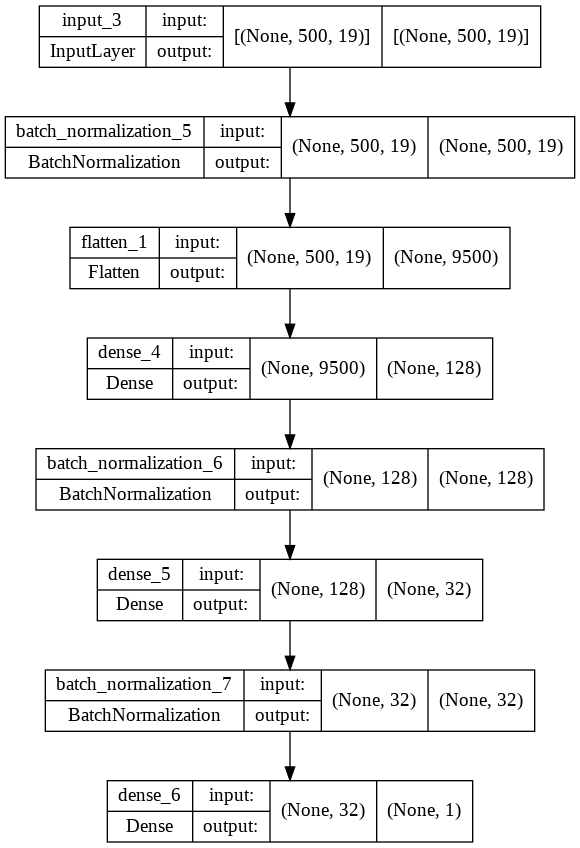

In [13]:
model_mlp.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model_mlp, show_shapes=True, expand_nested=True)

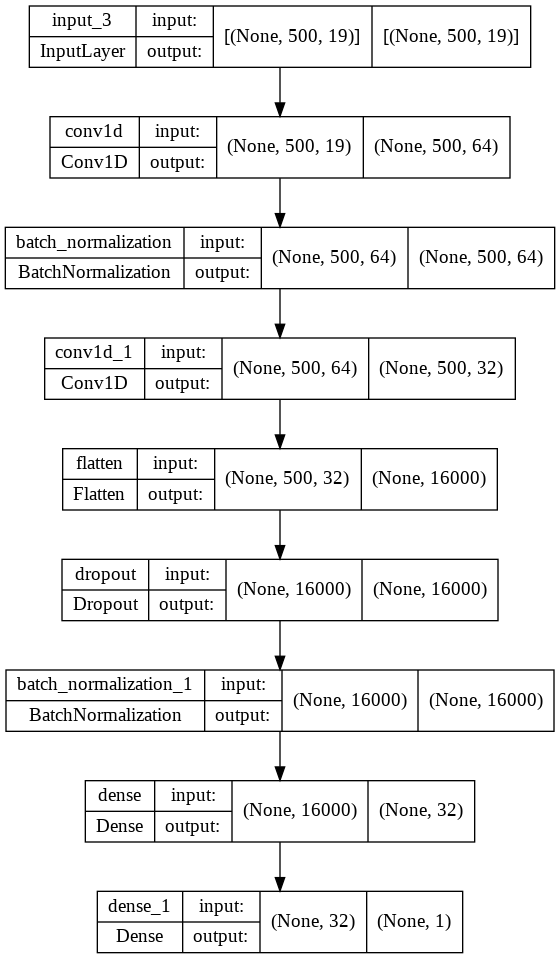

In [14]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model_cnn, show_shapes=True, expand_nested=True)

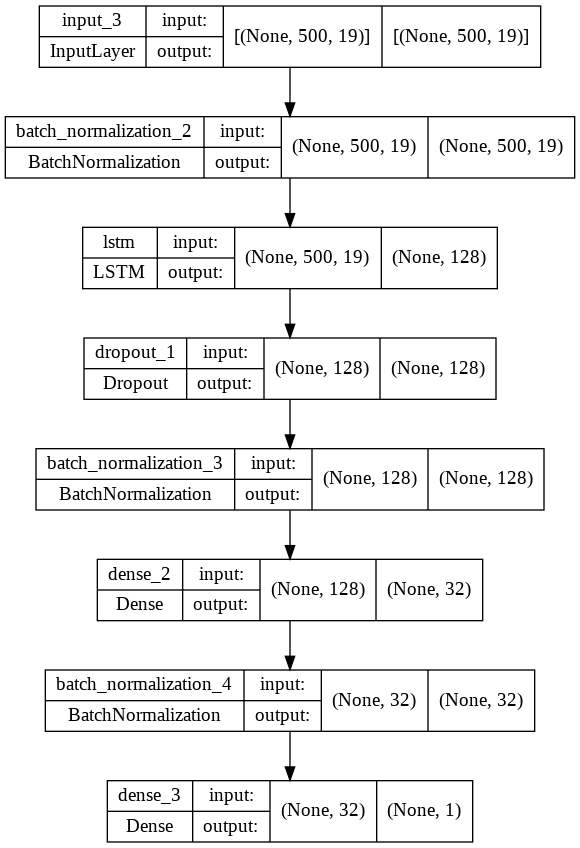

In [15]:
model_lstm.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model_lstm, show_shapes=True, expand_nested=True)

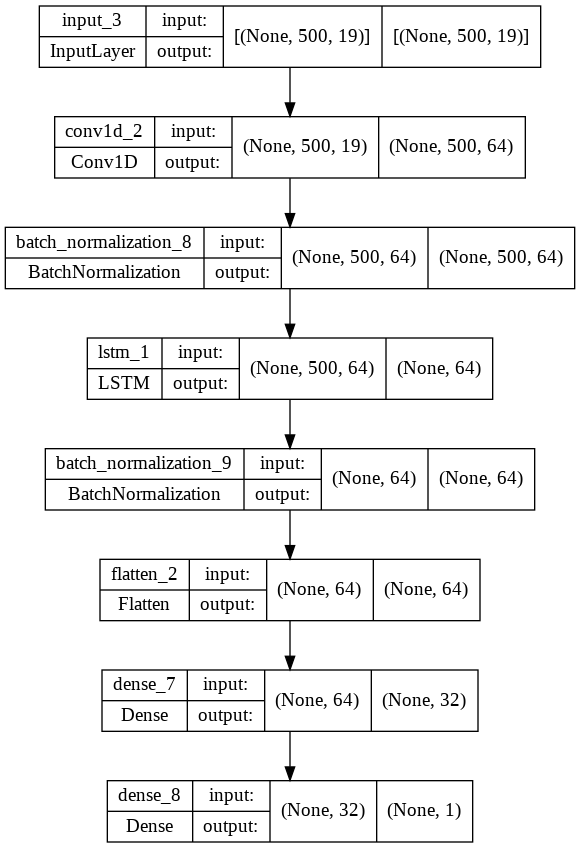

In [16]:
model_hyb.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model_hyb, show_shapes=True, expand_nested=True)

In [ ]:
epocas = 5

In [ ]:
history_mlp = model_mlp.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_mlp])

In [ ]:
history_cnn = model_cnn.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_cnn])

In [ ]:
history_lstm = model_lstm.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_lstm])

In [ ]:
history_hyb = model_hyb.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_hyb])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo MLP')

axs[0].plot(history_mlp.history['accuracy'], label='accuracy')
axs[0].plot(history_mlp.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_mlp.history['loss'], label='loss')
axs[1].plot(history_mlp.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo CNN',fontsize='x-large')

axs[0].plot(history_cnn.history['accuracy'], label='accuracy')
axs[0].plot(history_cnn.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_cnn.history['loss'], label='loss')
axs[1].plot(history_cnn.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo LSTM',fontsize='x-large')

axs[0].plot(history_lstm.history['accuracy'], label='accuracy')
axs[0].plot(history_lstm.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_lstm.history['loss'], label='loss')
axs[1].plot(history_lstm.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo Híbrido',fontsize='x-large')

axs[0].plot(history_hyb.history['accuracy'], label='accuracy')
axs[0].plot(history_hyb.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_hyb.history['loss'], label='loss')
axs[1].plot(history_hyb.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')